<a href="https://colab.research.google.com/github/AritraSarkar1203/Debutanizer_Column/blob/main/Debutanizer_GNN_withRadiusKNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
data = pd.read_csv('/content/debutanizer_data (1).txt',delim_whitespace=True)

print(data.head())

         u1        u2        u3        u4        u5        u6        u7  \
0  0.268900  0.650894  0.832742  0.583420  0.784759  0.843079  0.822079   
1  0.268483  0.650140  0.852153  0.577510  0.776487  0.838605  0.822079   
2  0.267967  0.659657  0.823618  0.571600  0.764546  0.807879  0.786246   
3  0.267451  0.668338  0.808371  0.565689  0.752605  0.799606  0.786246   
4  0.266935  0.647191  0.761948  0.559779  0.745326  0.773122  0.746142   

          y  
0  0.180295  
1  0.177124  
2  0.173618  
3  0.171640  
4  0.166972  


/tmp/ipython-input-76-343441779.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('/content/debutanizer_data (1).txt',delim_whitespace=True)


In [ ]:
!pip install torch_geometric

In [ ]:
print(data.isnull().sum())

u1    0
u2    0
u3    0
u4    0
u5    0
u6    0
u7    0
y     0
dtype: int64


In [ ]:
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from torch_geometric.data import Data
import torch
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import radius_graph


# Assuming 'data' DataFrame is already loaded and cleaned
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


A =kneighbors_graph(X_scaled,n_neighbors=5,mode='connectivity',include_self=False)

edge_index = torch.tensor(A.nonzero(), dtype=torch.long)

# Convert to PyG Data using scaled features
x = torch.tensor(X_scaled, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float).unsqueeze(1)

graph_data = Data(x=x, edge_index=edge_index, y=y)

In [ ]:
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.relu = nn.ReLU()
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
model = GNNModel(in_channels=7, hidden_channels=32, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
losses=[]
epochs = 3000
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(graph_data)
    loss = criterion(out, graph_data.y)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs} , Loss: {loss.item():.4f}")

Epoch 100/3000 , Loss: 0.0153
Epoch 200/3000 , Loss: 0.0127
Epoch 300/3000 , Loss: 0.0115
Epoch 400/3000 , Loss: 0.0108
Epoch 500/3000 , Loss: 0.0103
Epoch 600/3000 , Loss: 0.0099
Epoch 700/3000 , Loss: 0.0096
Epoch 800/3000 , Loss: 0.0092
Epoch 900/3000 , Loss: 0.0089
Epoch 1000/3000 , Loss: 0.0086
Epoch 1100/3000 , Loss: 0.0083
Epoch 1200/3000 , Loss: 0.0081
Epoch 1300/3000 , Loss: 0.0079
Epoch 1400/3000 , Loss: 0.0077
Epoch 1500/3000 , Loss: 0.0076
Epoch 1600/3000 , Loss: 0.0074
Epoch 1700/3000 , Loss: 0.0073
Epoch 1800/3000 , Loss: 0.0071
Epoch 1900/3000 , Loss: 0.0070
Epoch 2000/3000 , Loss: 0.0070
Epoch 2100/3000 , Loss: 0.0068
Epoch 2200/3000 , Loss: 0.0066
Epoch 2300/3000 , Loss: 0.0067
Epoch 2400/3000 , Loss: 0.0064
Epoch 2500/3000 , Loss: 0.0065
Epoch 2600/3000 , Loss: 0.0067
Epoch 2700/3000 , Loss: 0.0062
Epoch 2800/3000 , Loss: 0.0062
Epoch 2900/3000 , Loss: 0.0061
Epoch 3000/3000 , Loss: 0.0064


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

model.eval()
with torch.no_grad():
    predictions = model(graph_data).numpy()
    true = graph_data.y.numpy()
    rmse = mean_squared_error(true, predictions)
    r2 = r2_score(true, predictions)
    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

RMSE: 0.0064, R²: 0.7483


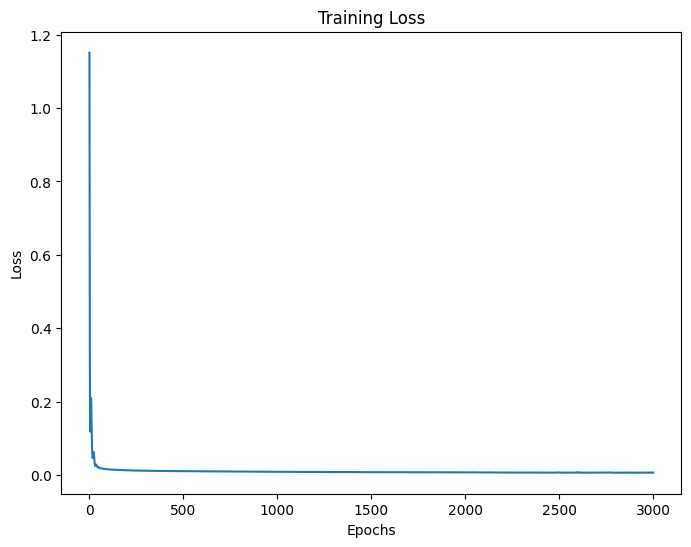

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

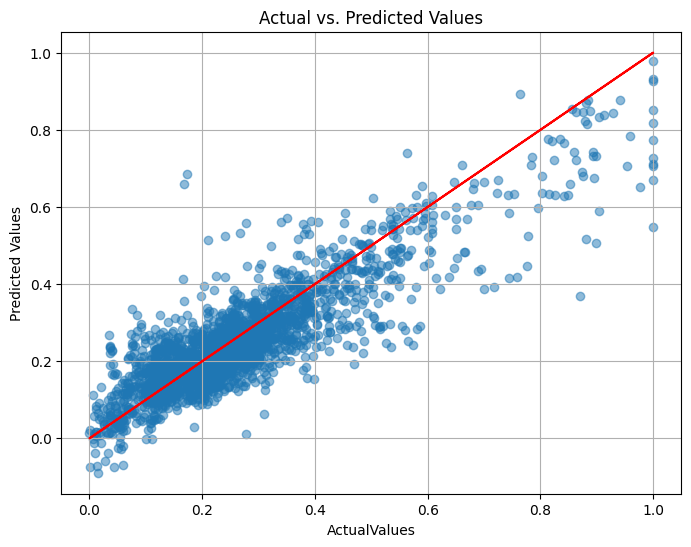

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(true, predictions, alpha=0.5)
plt.plot(true, true, color='red')
plt.xlabel("ActualValues")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.grid(True)
plt.show()

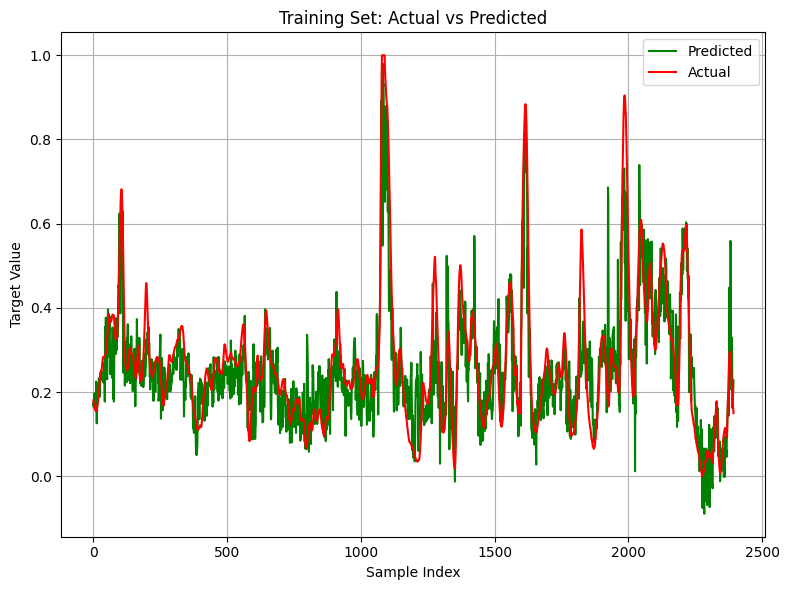

In [ ]:
with torch.no_grad():
    predictions = model(graph_data).numpy()
    true = graph_data.y.numpy()

plt.figure(figsize=(8,6))
plt.plot(predictions, label="Predicted" ,color="green")
plt.plot(true, label="Actual", color="red")
plt.title("Training Set: Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


radius neighbour graph

In [ ]:
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from torch_geometric.data import Data
import torch
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import radius_graph


# Assuming 'data' DataFrame is already loaded and cleaned
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



A=radius_neighbors_graph(X_scaled,radius=0.5, mode='connectivity',include_self=False)
edge_index = torch.tensor(A.nonzero(), dtype=torch.long)

# Convert to PyG Data using scaled features
x = torch.tensor(X_scaled, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float).unsqueeze(1)

graph_data = Data(x=x, edge_index=edge_index, y=y)

In [ ]:
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.relu = nn.ReLU()
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
model = GNNModel(in_channels=7, hidden_channels=32, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
losses=[]
epochs = 3000
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(graph_data)
    loss = criterion(out, graph_data.y)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs} , Loss: {loss.item():.4f}")

Epoch 100/3000 , Loss: 0.0147
Epoch 200/3000 , Loss: 0.0123
Epoch 300/3000 , Loss: 0.0110
Epoch 400/3000 , Loss: 0.0100
Epoch 500/3000 , Loss: 0.0092
Epoch 600/3000 , Loss: 0.0088
Epoch 700/3000 , Loss: 0.0083
Epoch 800/3000 , Loss: 0.0082
Epoch 900/3000 , Loss: 0.0078
Epoch 1000/3000 , Loss: 0.0076
Epoch 1100/3000 , Loss: 0.0074
Epoch 1200/3000 , Loss: 0.0072
Epoch 1300/3000 , Loss: 0.0071
Epoch 1400/3000 , Loss: 0.0073
Epoch 1500/3000 , Loss: 0.0069
Epoch 1600/3000 , Loss: 0.0068
Epoch 1700/3000 , Loss: 0.0066
Epoch 1800/3000 , Loss: 0.0066
Epoch 1900/3000 , Loss: 0.0064
Epoch 2000/3000 , Loss: 0.0064
Epoch 2100/3000 , Loss: 0.0062
Epoch 2200/3000 , Loss: 0.0062
Epoch 2300/3000 , Loss: 0.0061
Epoch 2400/3000 , Loss: 0.0061
Epoch 2500/3000 , Loss: 0.0063
Epoch 2600/3000 , Loss: 0.0060
Epoch 2700/3000 , Loss: 0.0060
Epoch 2800/3000 , Loss: 0.0059
Epoch 2900/3000 , Loss: 0.0058
Epoch 3000/3000 , Loss: 0.0058


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

model.eval()
with torch.no_grad():
    predictions = model(graph_data).numpy()
    true = graph_data.y.numpy()
    rmse = mean_squared_error(true, predictions)
    r2 = r2_score(true, predictions)
    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

RMSE: 0.0058, R²: 0.7702
